In [30]:
#libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [31]:
#loading datasets

current_dir = Path(os.getcwd()).parent

# # Adjust path based on your notebook location relative to data
# npz_path = current_dir / 'data'  / '2-Data' / 'GoldCoast' / 'current_wind_20100101_20241231_GoaldCoast.npz'

gc_npz = os.path.join(current_dir,'data', '2-Data',"GoldCoast", 
                           "current_wind_20100101_20241231_GoaldCoast.npz")
sy_npz = os.path.join(current_dir, 'data', '2-Data', "Sydney_NewCastle", 
                           "current_wind_20100101_20241231_Sydney.npz")


channel_names = ["U current", "V current", "Sea surface temp", 
                 "Salinity", "U wind", "V wind"]


gc_data = np.load(gc_npz)
sy_data = np.load(sy_npz)


gc_main = gc_data["UVTempSalt_UVTs"]  
sy_main = sy_data["UVTempSalt_UVTs"]

dates = pd.date_range("2010-01-01", "2024-12-31", freq="D")
sy_path = current_dir / 'data' / '2-Data' / 'GoldCoast' / 'goaldcoast_stings.csv'
gc_path = current_dir / 'data' / '2-Data' / 'Sydney_NewCastle' / 'Sydney_stings.csv'
sy = pd.read_csv(sy_path,
                 parse_dates=['time'], dayfirst=True)
gc = pd.read_csv(gc_path, 
                 parse_dates=['time'], dayfirst=True)

for df in (sy, gc):
    df['time'] = df['time'].dt.tz_localize(None)
    df['date'] = df['time'].dt.normalize()

sy['Region'] = 'Sydney'
gc['Region'] = 'Gold Coast'

stings = (pd.concat([sy, gc], ignore_index=True)
            .rename(columns={'Stings_sum':'stings_sum',
                             'Stings_binary':'stings_binary'})
            [['Region','date','stings_sum','stings_binary']])

In [32]:
# Checking grid size and valid ocean cells
# Mask is True where valid ocean data exist (not NaN for all time)

gc_mask = ~np.isnan(gc_main[:, 0, :, :]).all(axis=0)
sy_mask = ~np.isnan(sy_main[:, 0, :, :]).all(axis=0)

print("Gold Coast grid:", gc_mask.shape, "valid ocean cells:", gc_mask.sum())
print("Sydney grid:", sy_mask.shape, "valid ocean cells:", sy_mask.sum())


Gold Coast grid: (15, 15) valid ocean cells: 183
Sydney grid: (13, 13) valid ocean cells: 118


In [33]:
#converting masked 4D array (time, channel, H, W) into a dataframe with daily averages for each channel

def make_df(region_name, data, mask, dates, channels):
    T, C, H, W = data.shape
    rows = {}
    for i, chn in enumerate(channels):
        masked_vals = data[:, i, :, :][:, mask] #only take ocean cells
        daily_avg = np.nanmean(masked_vals, axis=1)
        rows[chn] = daily_avg
    df = pd.DataFrame(rows, index=dates)
    df.index.name = "Date"
    df["Region"] = region_name
    return df

gc_df = make_df("Gold Coast", gc_main, gc_mask, dates, channel_names)
sy_df = make_df("Sydney", sy_main, sy_mask, dates, channel_names)

all_df = pd.concat([gc_df, sy_df])
all_df.head(10)


U current  V current  Sea surface temp   Salinity    U wind  \
Date                                                                      
2010-01-01  -0.101543  -0.682206         25.984117  35.310858 -1.350650   
2010-01-02  -0.035152  -0.685357         25.928812  35.348238  1.565029   
2010-01-03  -0.230347  -0.546167         26.009888  35.358243 -3.923860   
2010-01-04  -0.192440  -0.600306         25.745936  35.374060 -6.002225   
2010-01-05  -0.178490  -0.552857         25.732278  35.371389 -5.123858   
2010-01-06  -0.133753  -0.498218         25.921495  35.365305 -2.511772   
2010-01-07  -0.213470  -0.417091         26.086436  35.383106 -4.707287   
2010-01-08  -0.211123  -0.367580         26.116103  35.388099 -5.255721   
2010-01-09  -0.171594  -0.365517         26.233437  35.406379 -3.370998   
2010-01-10  -0.139649  -0.379221         26.666425  35.370313 -1.978729   

              V wind      Region  
Date                              
2010-01-01 -6.638138  Gold Coast  
2010-01-02 -8.252087  Gold Coast  
2010-01-03  6.502674  Gold Coast  
2010-01-04  6.037926  Gold Coast  
2010-01-05  2.970986  Gold Coast  
2010-01-06 -1.456332  Gold Coast  
2010-01-07  0.398544  Gold Coast  
2010-01-08  1.778475  Gold Coast  
2010-01-09 -0.287061  Gold Coast  
2010-01-10 -1.203467  Gold Coast

In [34]:
#statistical summary

summary = all_df.groupby("Region").agg(
    ["mean", "std", "min", "max"])
summary

U current                               V current            \
                mean       std       min       max      mean       std   
Region                                                                   
Gold Coast -0.008911  0.099859 -0.366549  0.411589 -0.366857  0.188741   
Sydney     -0.152917  0.168359 -0.713490  0.319542 -0.248096  0.237114   

                               Sea surface temp            ...   Salinity  \
                 min       max             mean       std  ...        min   
Region                                                     ...              
Gold Coast -1.084770  0.231902        24.025299  1.912614  ...  34.959118   
Sydney     -1.070762  0.417203        21.680250  2.138813  ...  35.133101   

                         U wind                                    V wind  \
                  max      mean       std        min        max      mean   
Region                                                                      
Gold Coast  35.836392 -1.358530  3.889554 -17.033267  12.591706  0.626570   
Sydney      35.819766 -0.161382  4.461667 -16.176857  16.230287  0.034393   

                                            
                 std        min        max  
Region                                      
Gold Coast  5.435193 -13.545776  17.736387  
Sydney      5.493073 -12.615044  17.403279  

[2 rows x 24 columns]

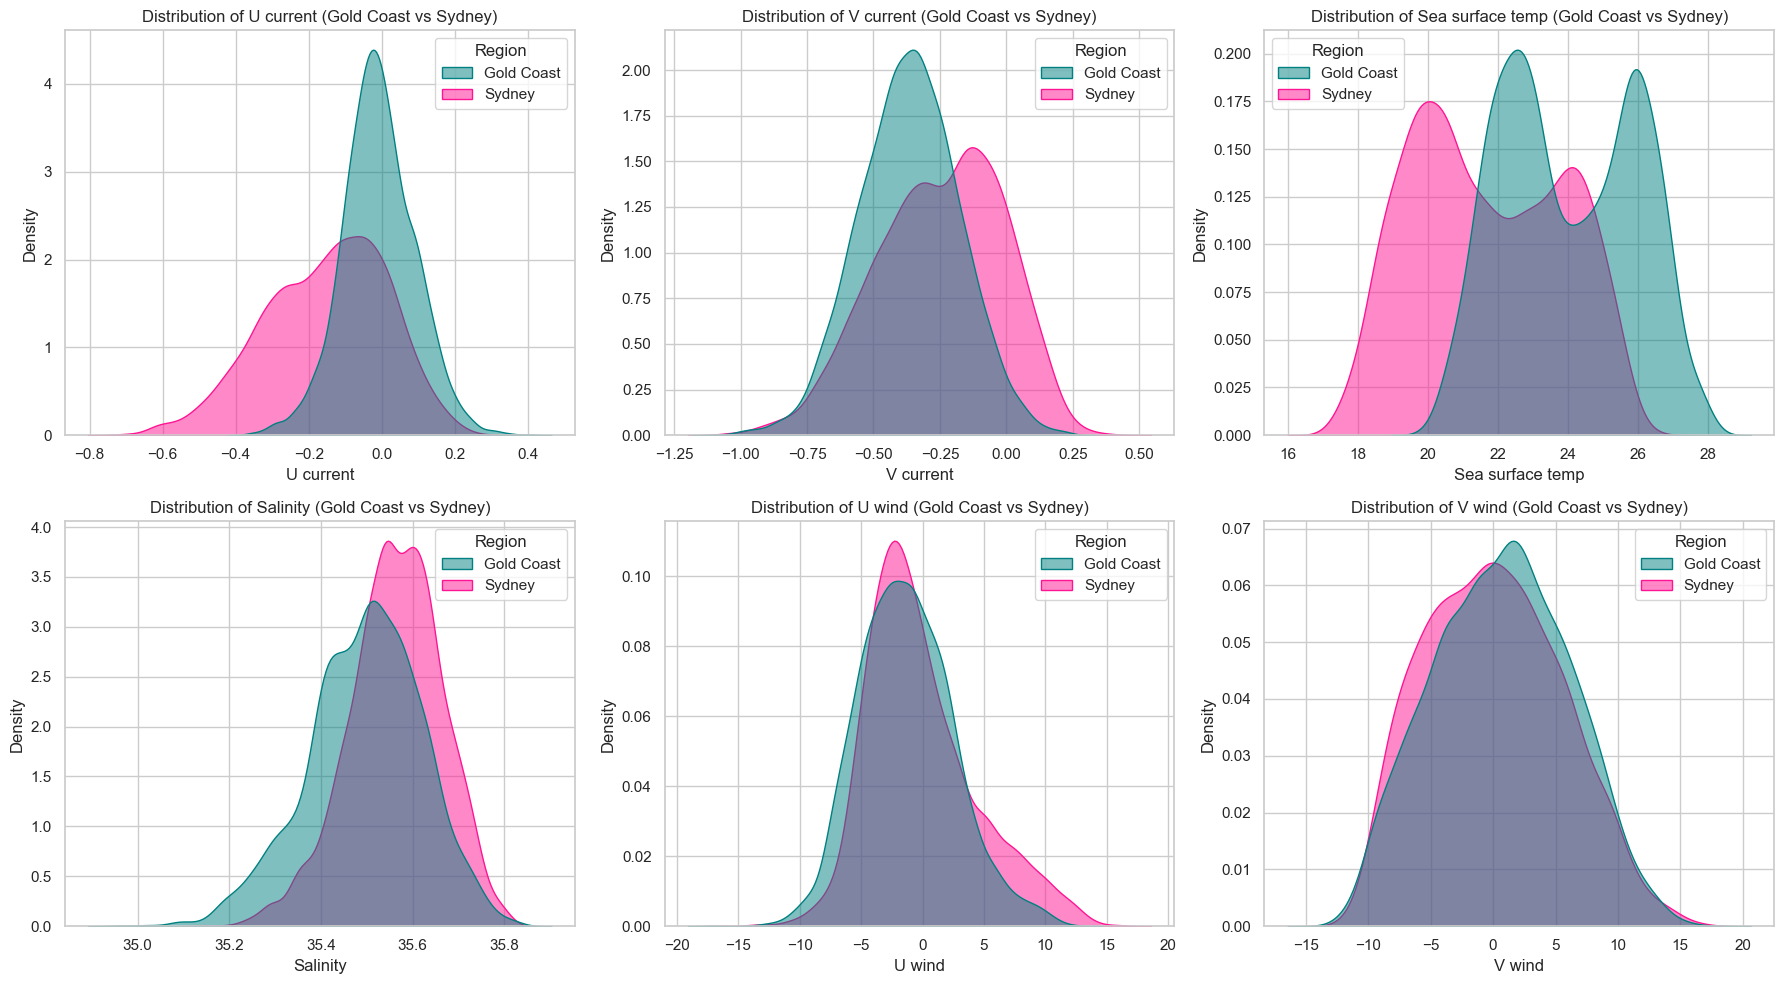

In [35]:
#environmental variables distributions 

palette = {"Gold Coast": "#008080", "Sydney": "#FF1493"}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  #2x3 grid
axes = axes.flatten()  

for i, evar in enumerate(channel_names):
    sns.kdeplot(
        data=all_df, x=evar, hue="Region",
        fill=True, common_norm=False, alpha=0.5,
        palette=palette, ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {evar} (Gold Coast vs Sydney)")
    axes[i].set_xlabel(evar)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

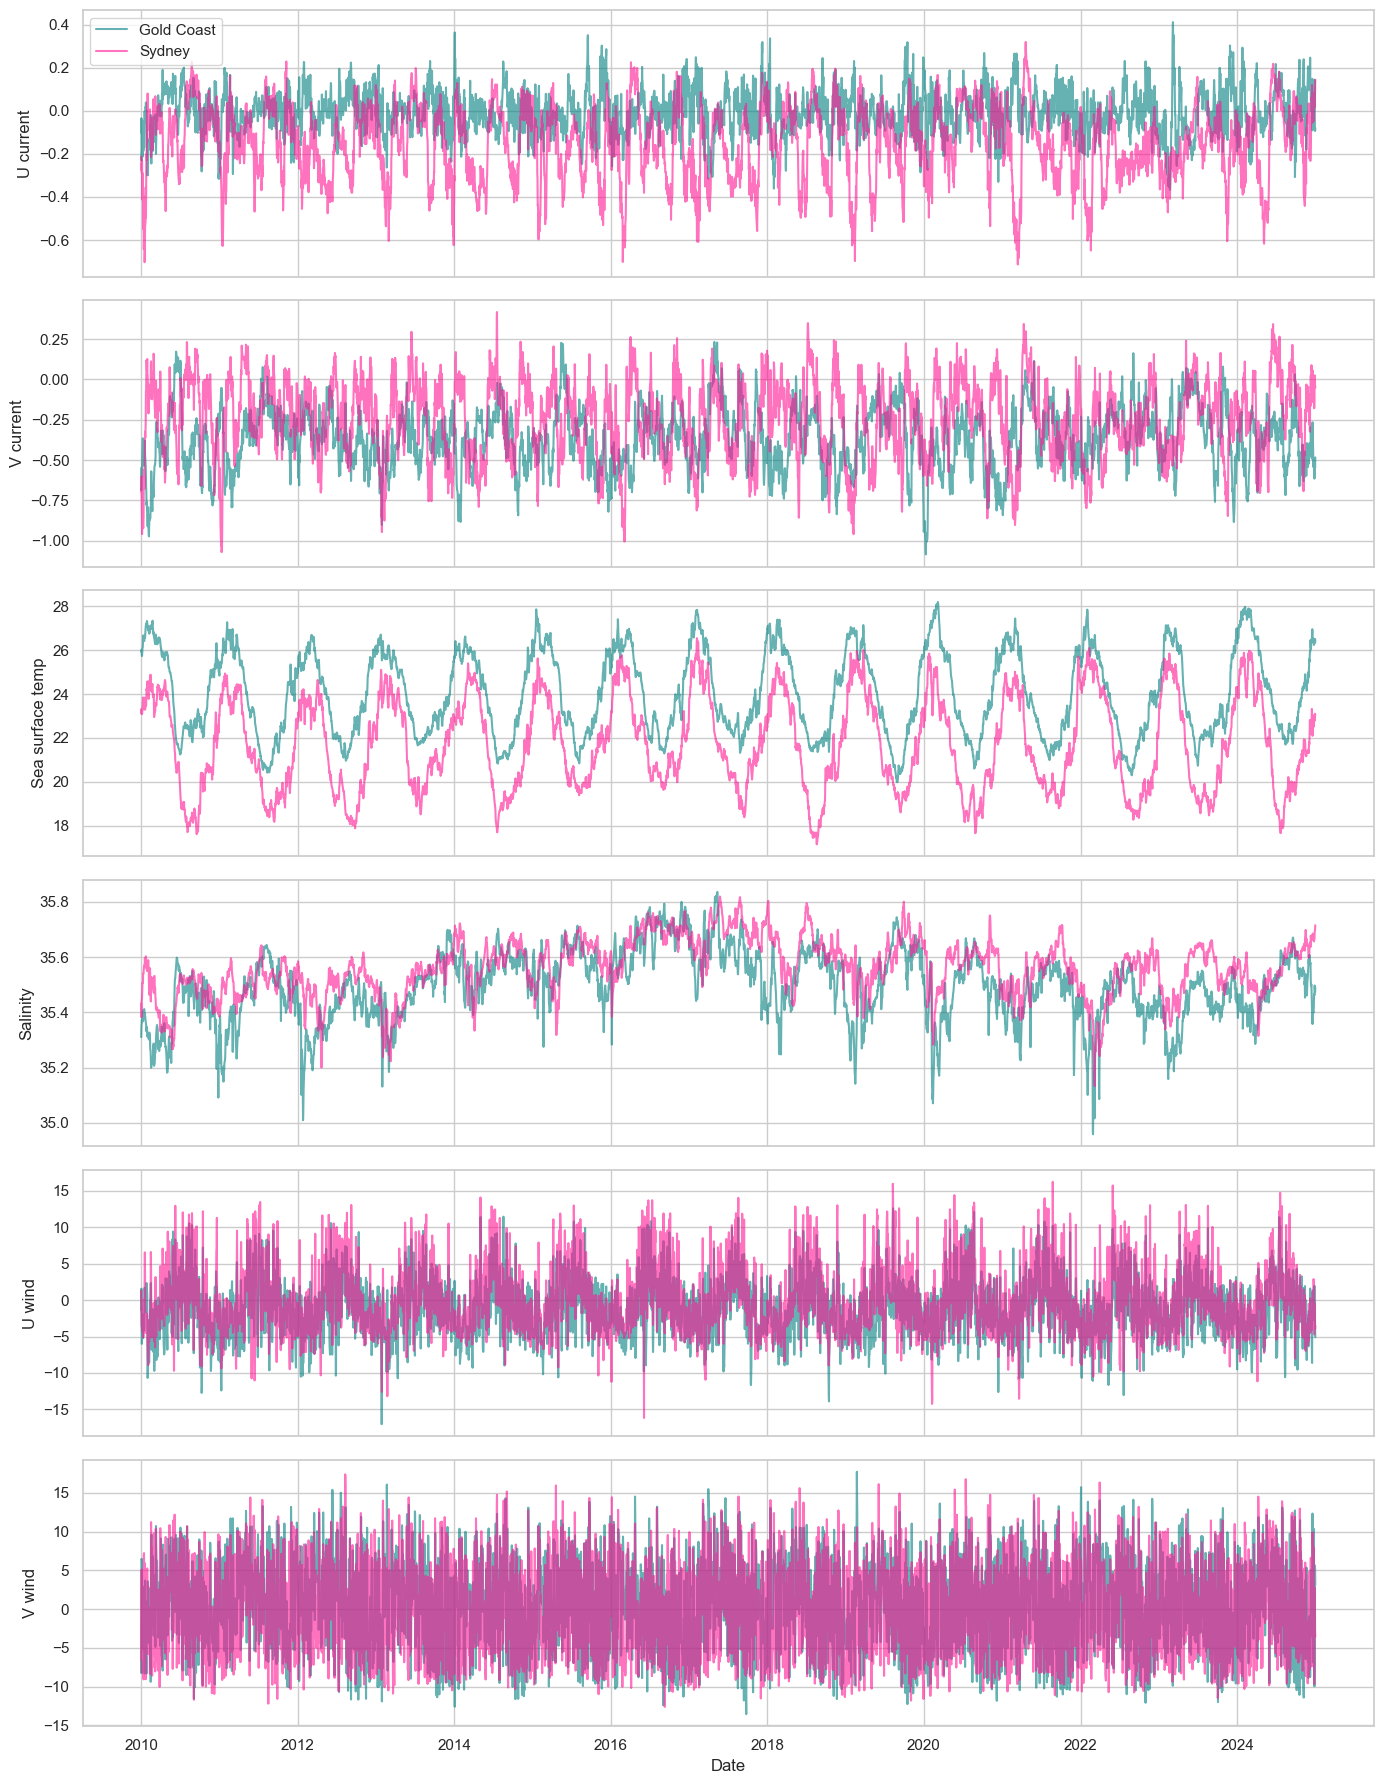

In [36]:
#time series analysis 

fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)

for i, evar in enumerate(channel_names):
    ax = axes[i]
    ax.plot(gc_df.index, gc_df[evar], 
            label="Gold Coast", color=palette["Gold Coast"], alpha=0.6)
    ax.plot(sy_df.index, sy_df[evar], 
            label="Sydney", color=palette["Sydney"], alpha=0.6)
    
    ax.set_ylabel(evar)
    if i == 0:
        ax.legend()
    if i == 5:
        ax.set_xlabel("Date")

plt.tight_layout()
plt.show()


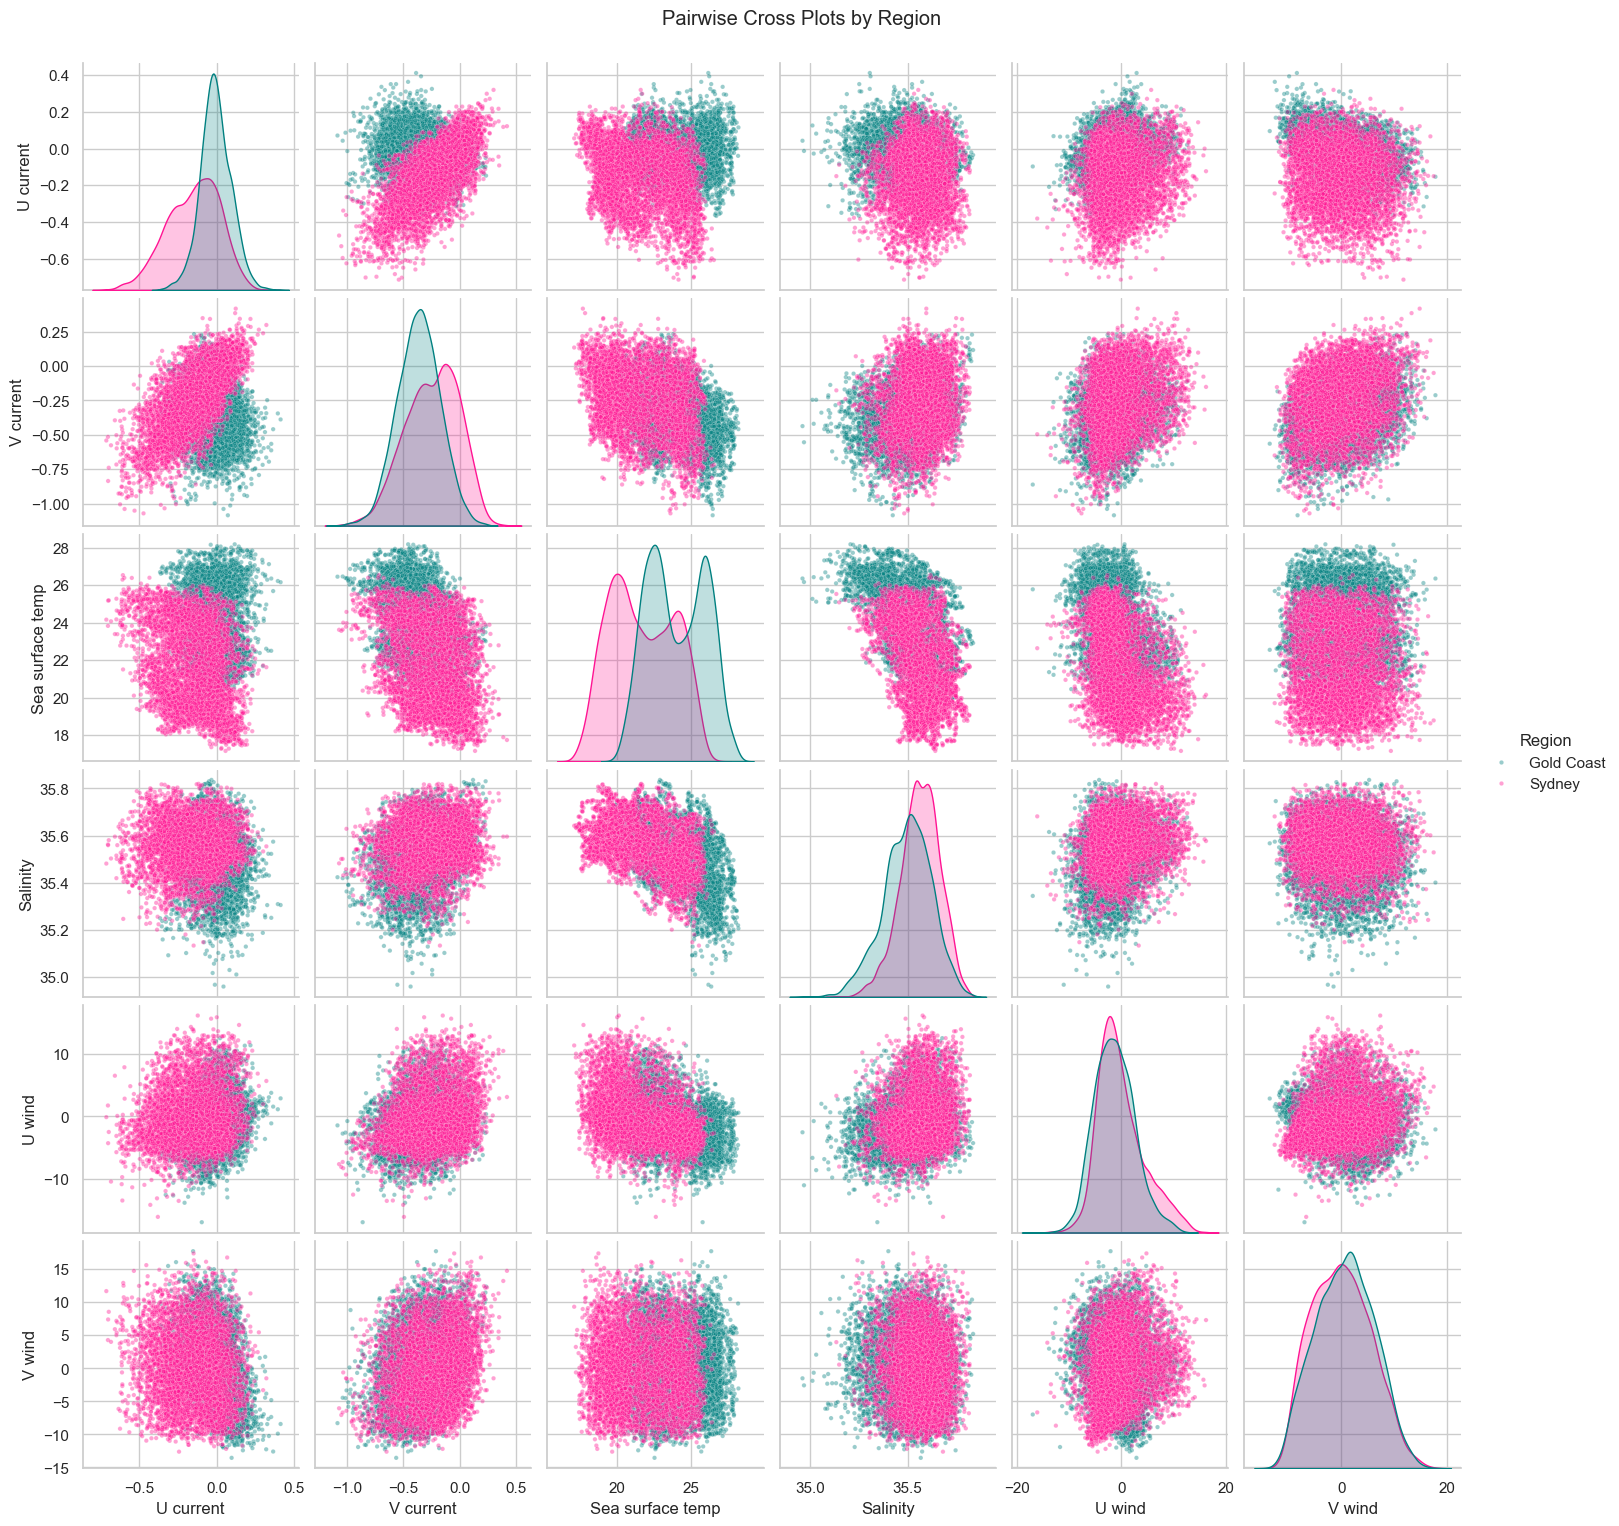

In [37]:
#cross plots by region
sns.set(style="whitegrid")
cp = sns.pairplot(
    all_df,
    vars=["U current", "V current", "Sea surface temp", "Salinity", "U wind", "V wind"],
    hue="Region",
    diag_kind="kde",
    palette=palette,
    plot_kws={"alpha":0.4, "s":10})
cp.fig.suptitle("Pairwise Cross Plots by Region", y=1.02)
plt.show()

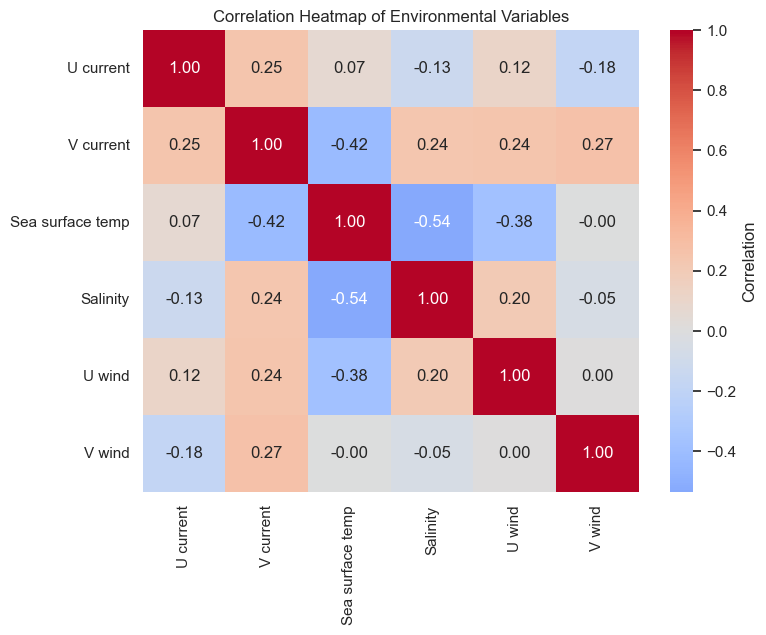

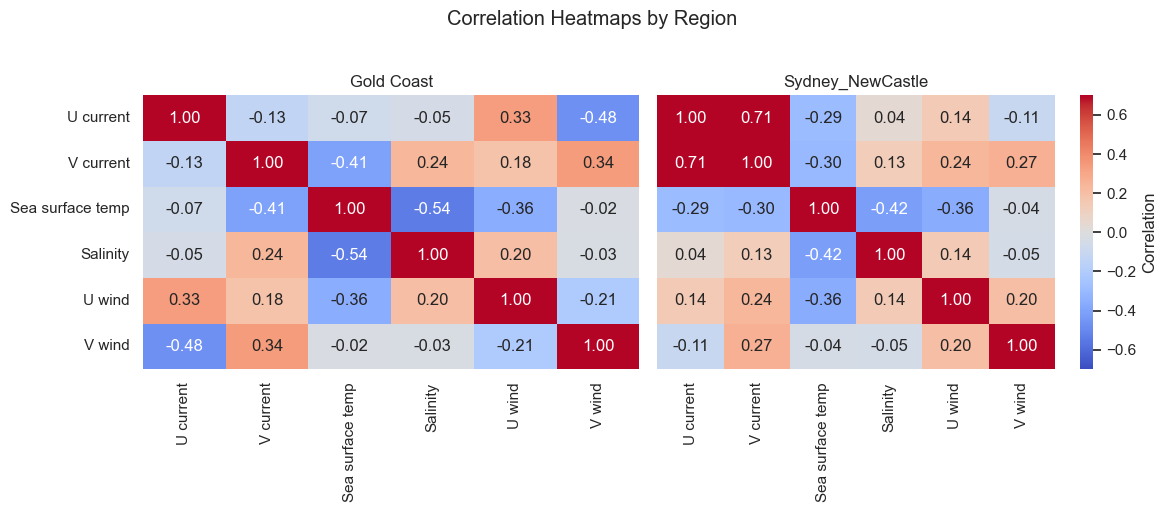

In [38]:
#correlation heatmap

corr = all_df.drop(columns=["Region"]).corr()
cmap = "coolwarm"   
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap=cmap, center=0,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap of Environmental Variables")
plt.show()

#correlation heatmaps by region

e_vars = ["U current","V current","Sea surface temp","Salinity","U wind","V wind"]
corr_gc = gc_df[e_vars].corr()
corr_sy = sy_df[e_vars].corr()
cmap = "coolwarm" 

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

sns.heatmap(corr_gc, ax=axes[0], cmap=cmap, center=0, vmin=-0.7, vmax=0.7,
            annot=True, fmt=".2f", cbar=False)
axes[0].set_title("Gold Coast")

sns.heatmap(corr_sy, ax=axes[1], cmap=cmap, center=0, vmin=-0.7, vmax=0.7,
            annot=True, fmt=".2f", cbar_kws={'label':'Correlation'})
axes[1].set_title("Sydney_NewCastle")

plt.suptitle("Correlation Heatmaps by Region", y=1.02)
plt.tight_layout()
plt.show()



Summary for Sydney
count     797.000000
mean       32.899624
std       108.964184
min         0.000000
25%         0.000000
50%         0.000000
75%        24.000000
max      1704.000000
Name: stings_sum, dtype: float64
Binary counts:
 stings_Binary
0    0.715182
1    0.284818
Name: proportion, dtype: float64

Summary for Gold Coast
count    1821.000000
mean       53.672158
std       221.514938
min         0.000000
25%         0.000000
50%         0.000000
75%        23.000000
max      4450.000000
Name: stings_sum, dtype: float64
Binary counts:
 stings_binary
0    0.731466
1    0.268534
Name: proportion, dtype: float64


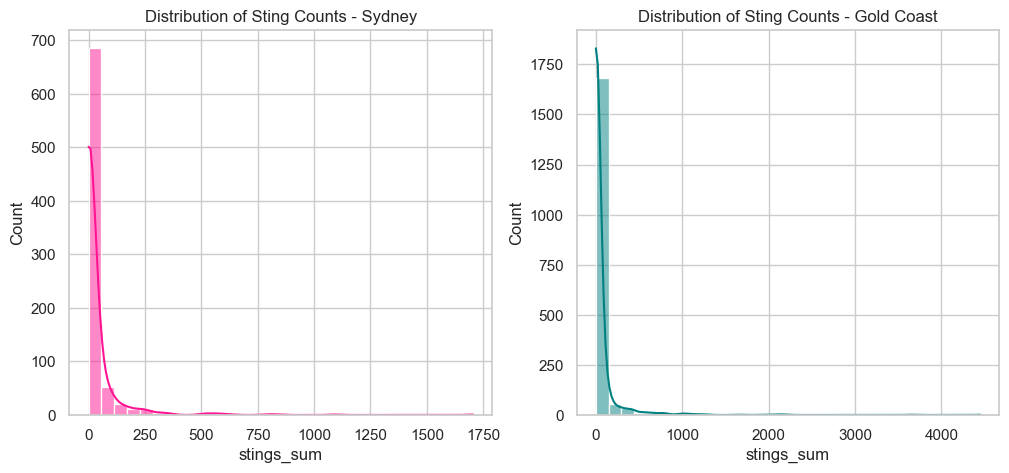

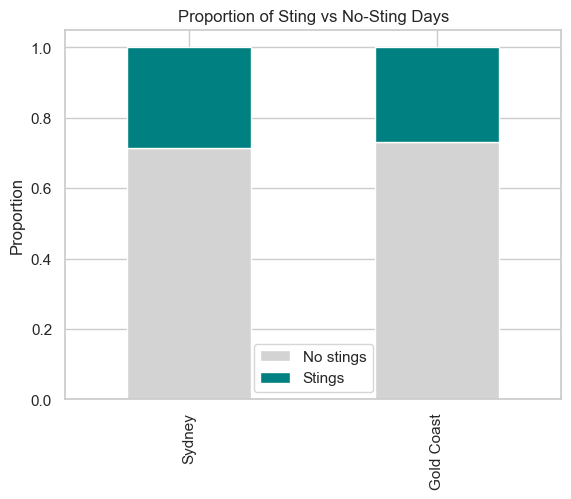

In [39]:
#exploring sting data 

def sting_summary(df, region):
    print(f"\nSummary for {region}")
    print(df["stings_sum"].describe())
    if "Sydney" in region:
        print("Binary counts:\n", df["stings_Binary"].value_counts(normalize=True))
    else:
        print("Binary counts:\n", df["stings_binary"].value_counts(normalize=True))

sting_summary(sy, "Sydney")
sting_summary(gc, "Gold Coast")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(sy["stings_sum"], bins=30, kde=True, color=palette["Sydney"], ax=axes[0])
axes[0].set_title("Distribution of Sting Counts - Sydney")

sns.histplot(gc["stings_sum"], bins=30, kde=True, color=palette["Gold Coast"], ax=axes[1])
axes[1].set_title("Distribution of Sting Counts - Gold Coast")

plt.show()


binary_df = pd.DataFrame({
    "Sydney": sy["stings_Binary"].value_counts(normalize=True),
    "Gold Coast": gc["stings_binary"].value_counts(normalize=True)
}).T

binary_df.plot(kind="bar", stacked=True, color=["lightgray","teal"])
plt.title("Proportion of Sting vs No-Sting Days")
plt.ylabel("Proportion")
plt.legend(["No stings","Stings"])
plt.show()

In [40]:
#matching sting data with environment data

def daily_env_from_np(arr, region, channels):
    means = np.nanmean(arr, axis=(2, 3))  
    out = pd.DataFrame(means, columns=channels)
    out['date'] = dates
    out['Region'] = region
    return out

gc_env = daily_env_from_np(gc_main, 'Gold Coast', channel_names)
sy_env = daily_env_from_np(sy_main, 'Sydney', channel_names)

env_daily = pd.concat([gc_env, sy_env], ignore_index=True)
merged = env_daily.merge(stings, on=['Region','date'], how='inner')

print('Sydney rows:', (merged.Region=='Sydney').sum(),
      'Gold Coast rows:', (merged.Region=='Gold Coast').sum(),
      'Total:', len(merged))


Sydney rows: 744 Gold Coast rows: 1658 Total: 2402


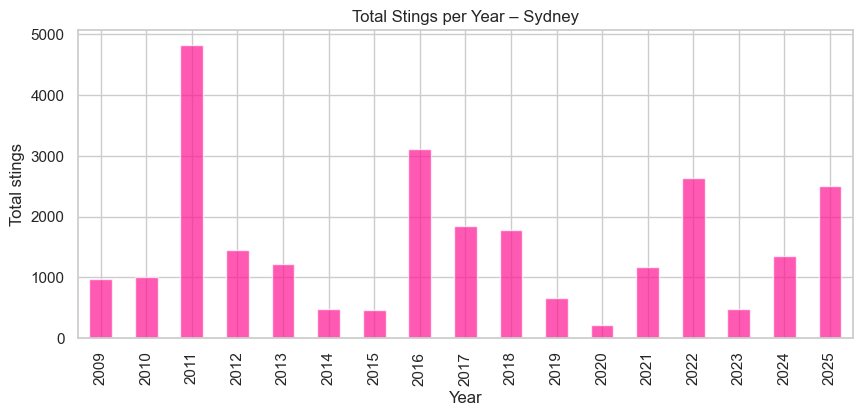

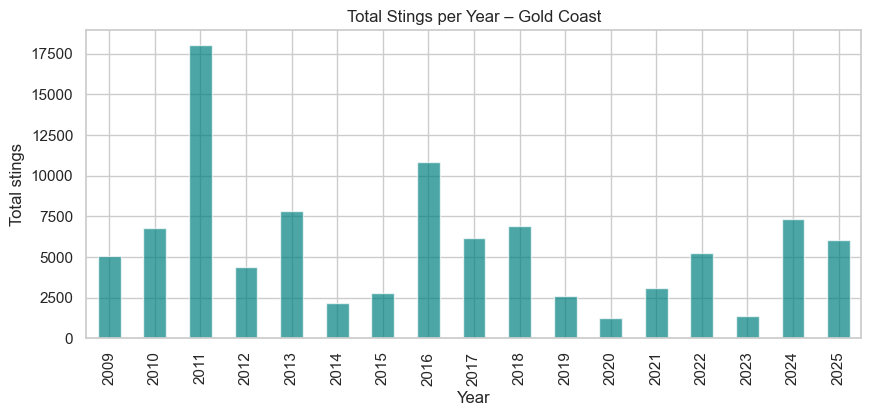

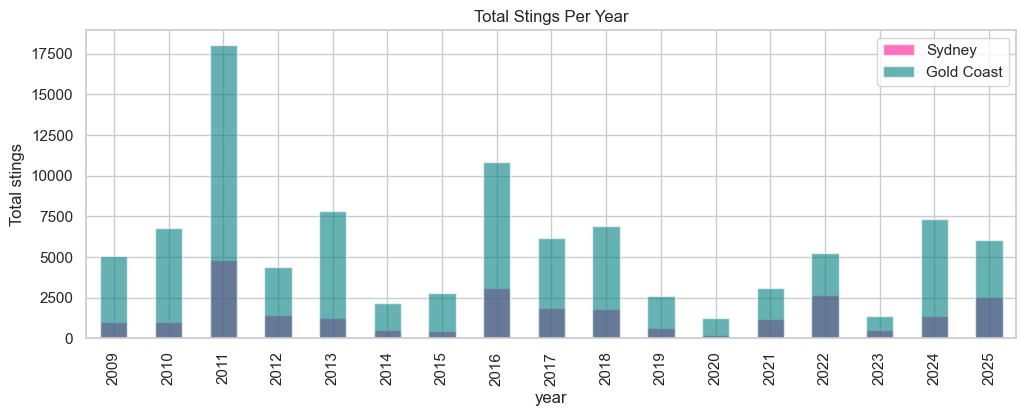

In [41]:
#yearly trends for stings

sy['year'] = sy['date'].dt.year
gc['year'] = gc['date'].dt.year

# Sydney yearly trend
plt.figure(figsize=(10,4))
sy.groupby('year')['stings_sum'].sum().plot(
    kind='bar', color='deeppink', alpha=0.7
)
plt.title('Total Stings per Year – Sydney')
plt.ylabel('Total stings')
plt.xlabel('Year')
plt.show()

# Gold Coast yearly trend
plt.figure(figsize=(10,4))
gc.groupby('year')['stings_sum'].sum().plot(
    kind='bar', color='teal', alpha=0.7
)
plt.title('Total Stings per Year – Gold Coast')
plt.ylabel('Total stings')
plt.xlabel('Year')
plt.show()

#combined
plt.figure(figsize=(12,4))
sy.groupby('year')['stings_sum'].sum().plot(kind='bar', alpha=0.6, color='deeppink', label='Sydney')
gc.groupby('year')['stings_sum'].sum().plot(kind='bar', alpha=0.6, color='teal', label='Gold Coast')
plt.title('Total Stings Per Year')
plt.ylabel('Total stings')
plt.legend()
plt.show()



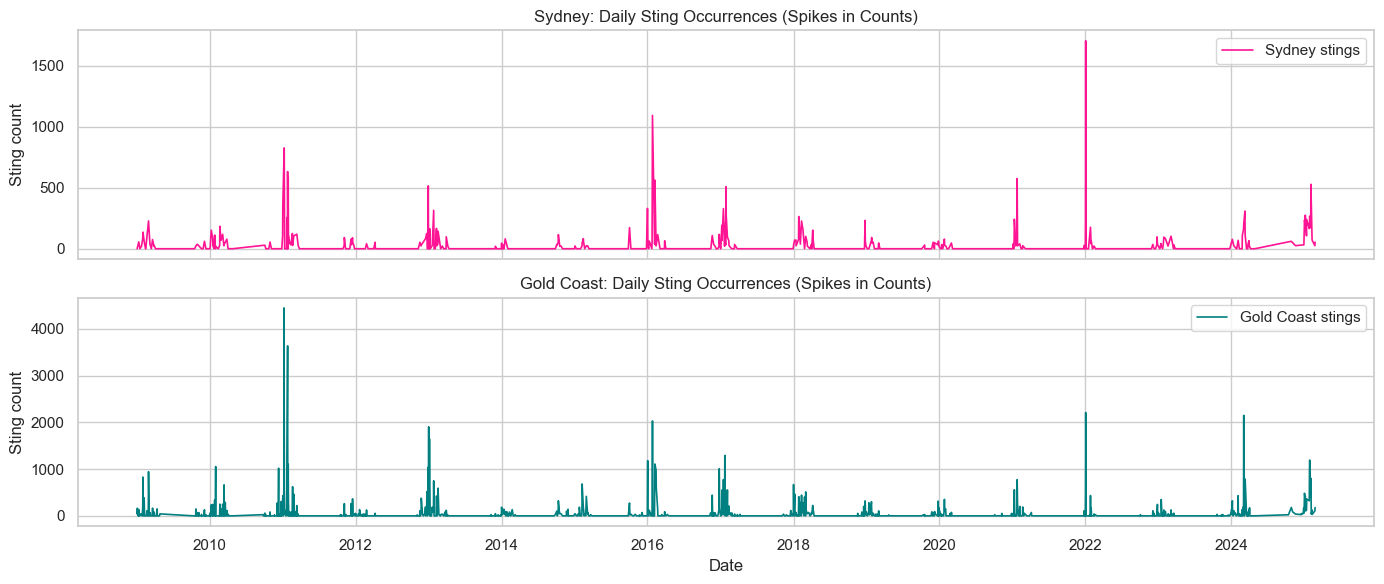

In [42]:
#time series plot of daily sting occurrences

sy_plot = sy.set_index('date').sort_index()
gc_plot = gc.set_index('date').sort_index()
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Sydney plot
axes[0].plot(sy_plot.index, sy_plot['stings_sum'].fillna(0),
             color='deeppink', linewidth=1.2, label='Sydney stings')
axes[0].set_title("Sydney: Daily Sting Occurrences (Spikes in Counts)")
axes[0].set_ylabel("Sting count")
axes[0].legend()

# Gold Coast
axes[1].plot(gc_plot.index, gc_plot['stings_sum'].fillna(0),
             color='teal', linewidth=1.2, label='Gold Coast stings')
axes[1].set_title("Gold Coast: Daily Sting Occurrences (Spikes in Counts)")
axes[1].set_ylabel("Sting count")
axes[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\VJ\anaconda3\envs\bluebottle\lib\sit

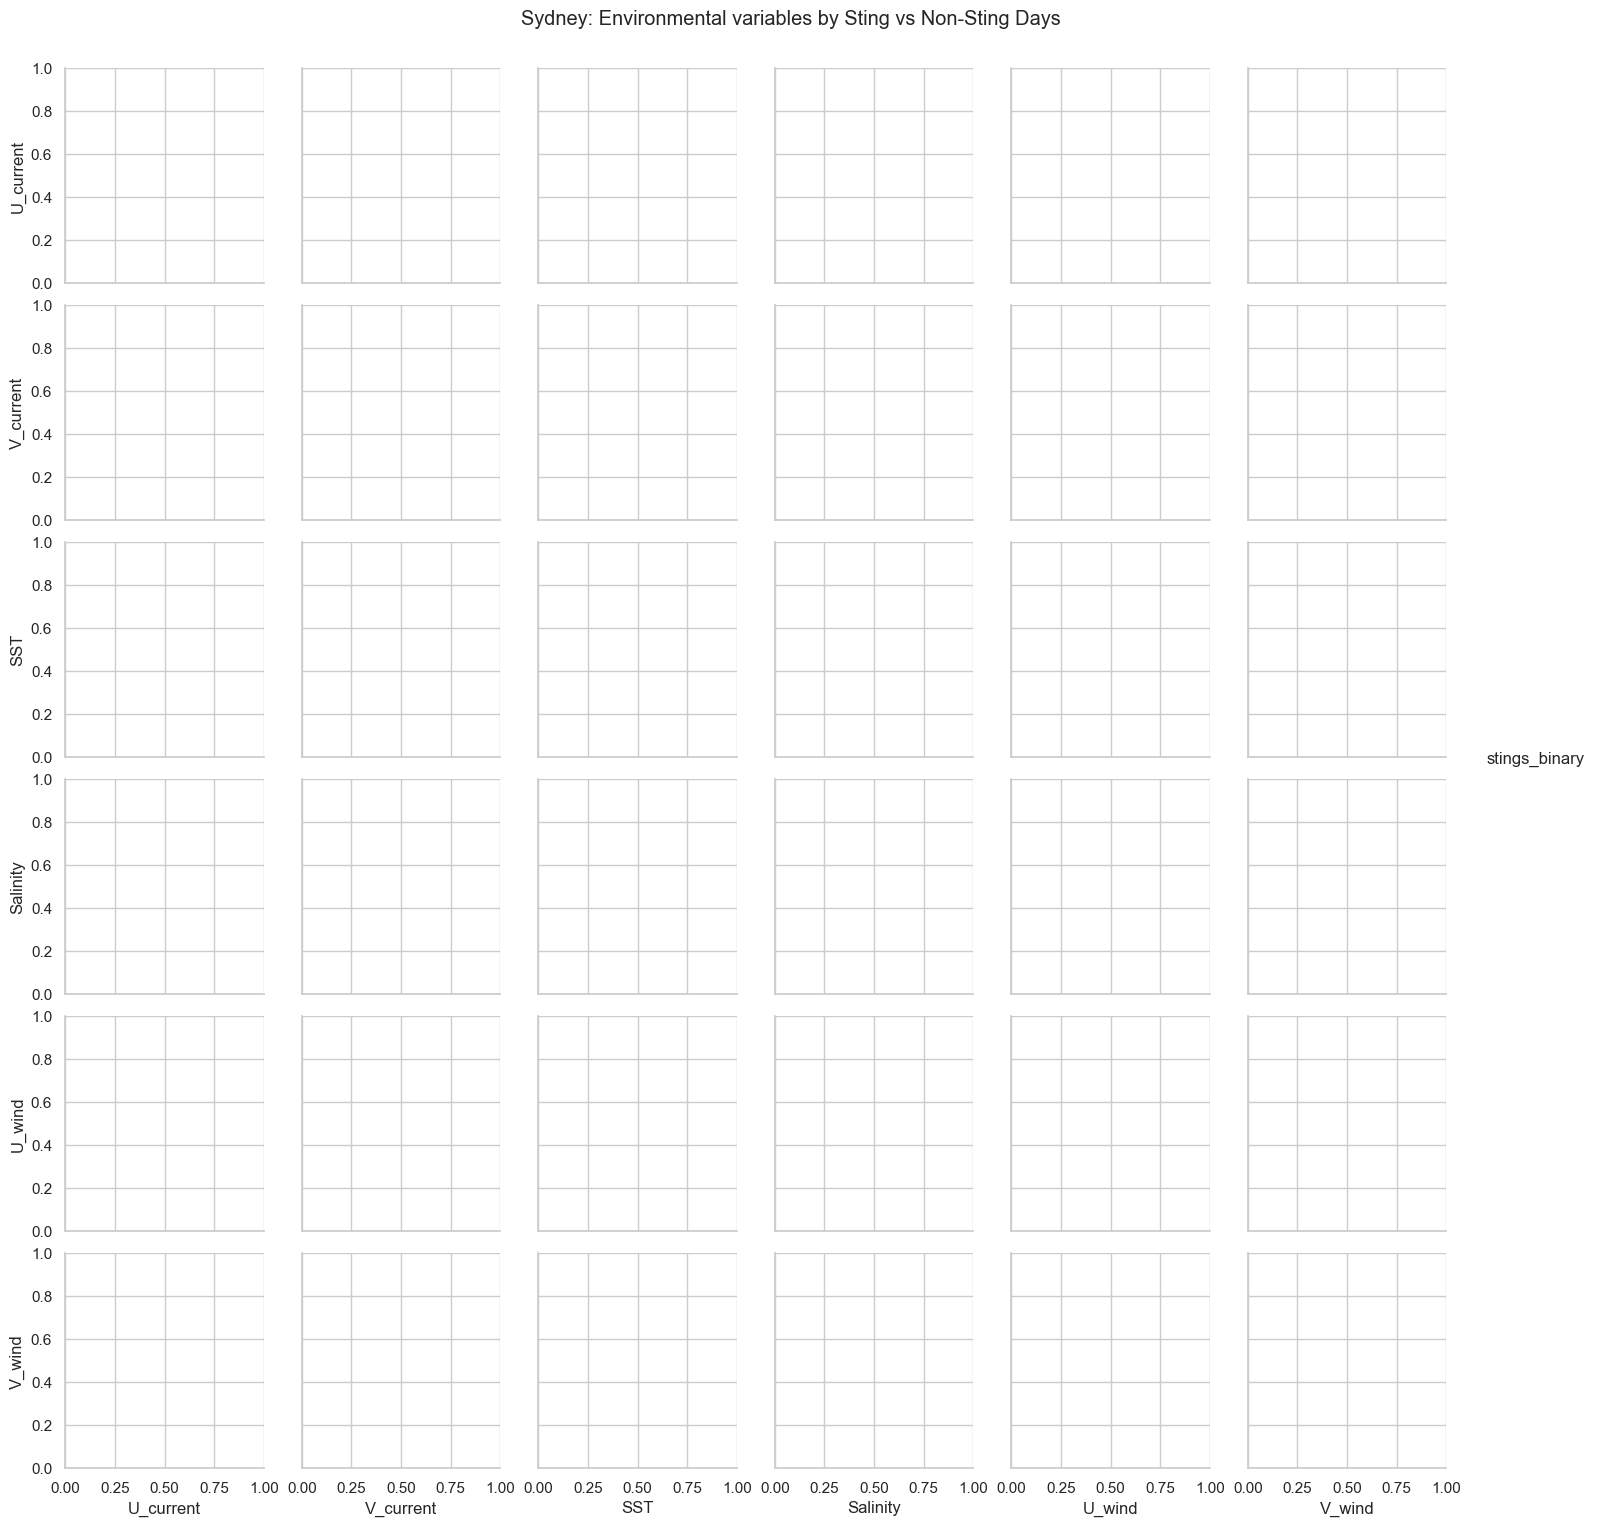

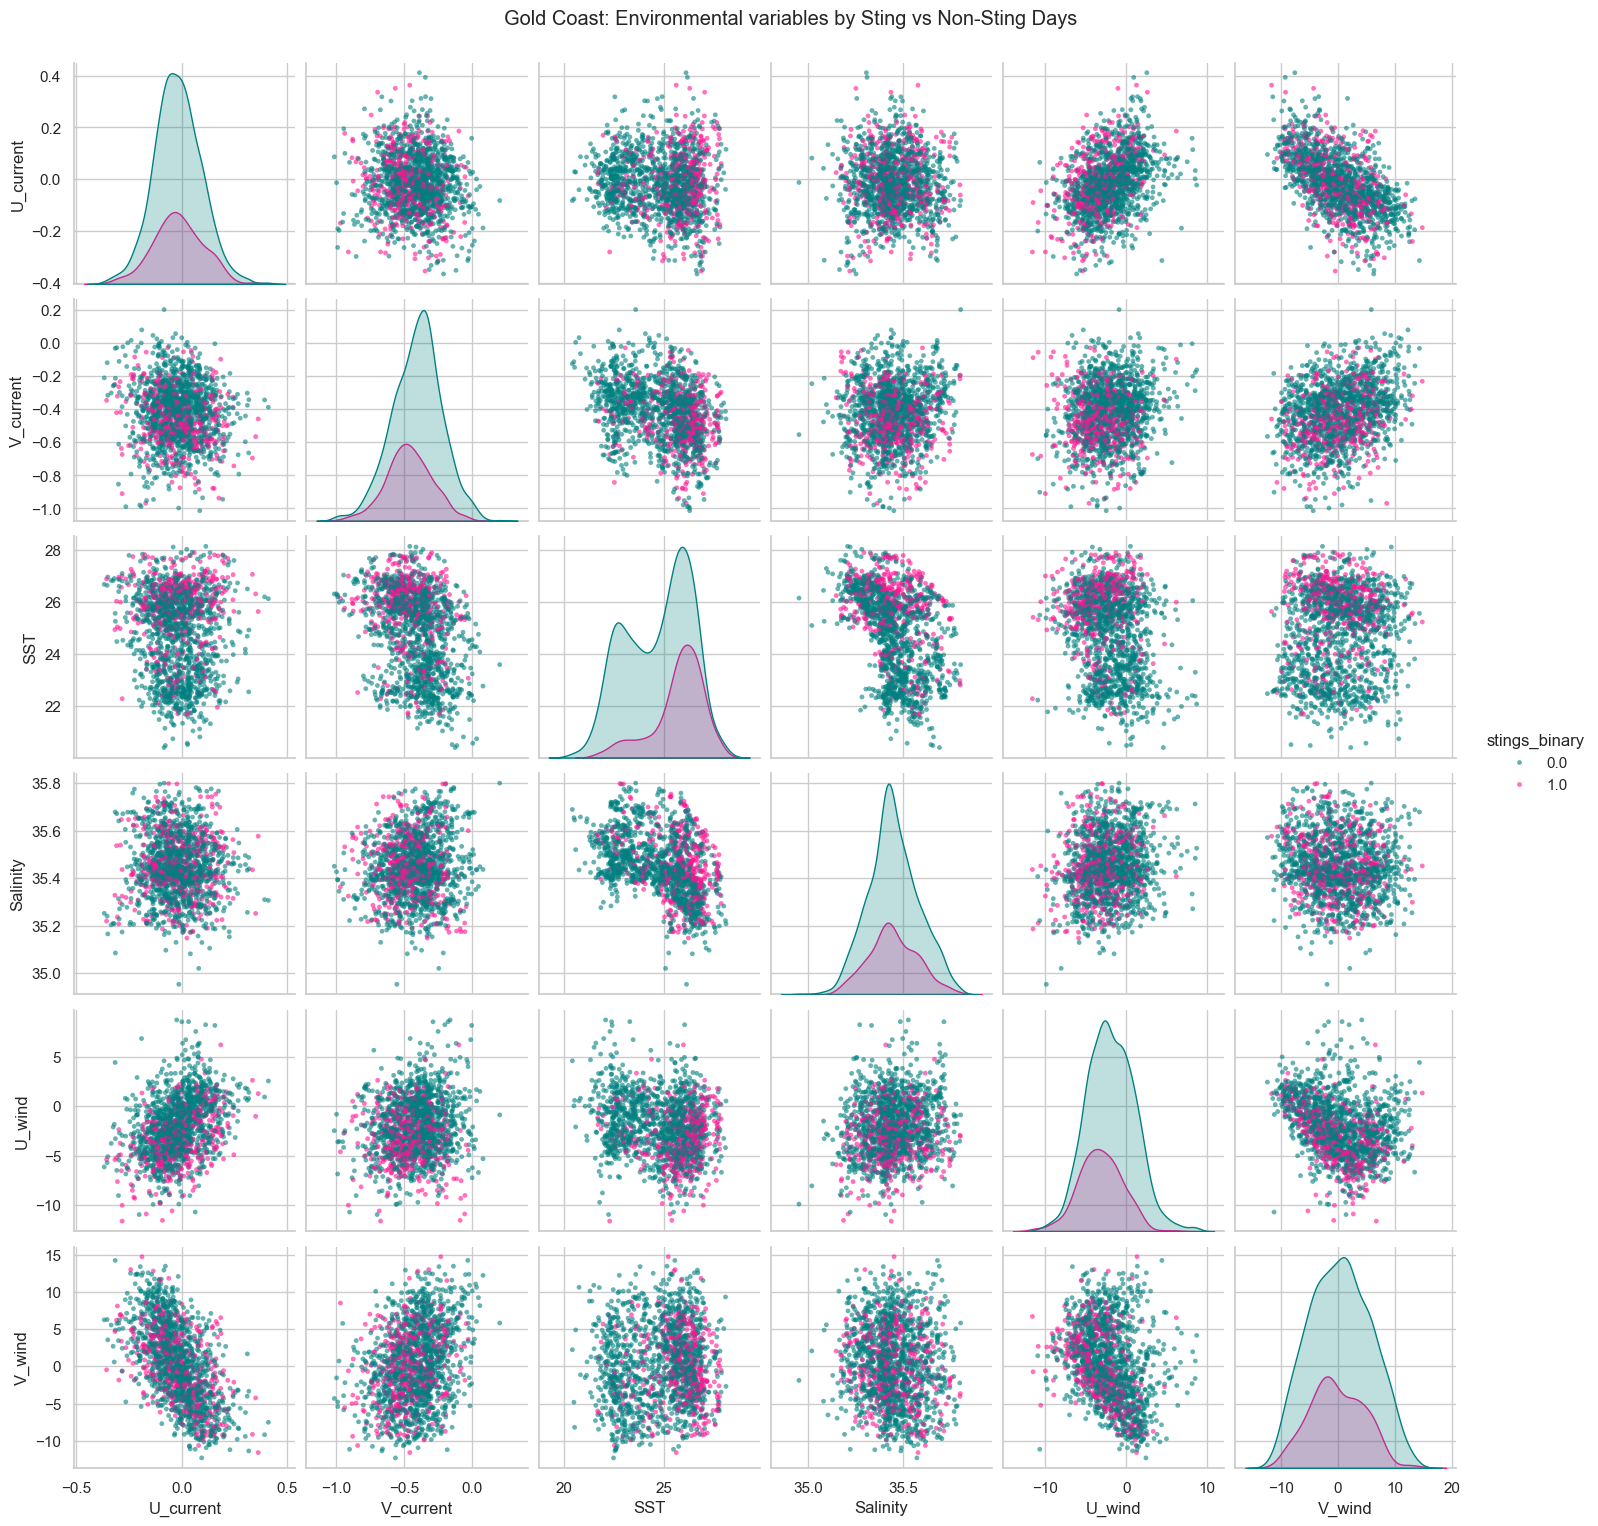

In [43]:
#cross plots of environmental varibles with sting days

rename_map = {
    "U current":"U_current",
    "V current":"V_current",
    "Sea surface temp":"SST",
    "Salinity":"Salinity",
    "U wind":"U_wind",
    "V wind":"V_wind"
}
df = merged.rename(columns=rename_map, errors="ignore")

#Sydney
sy_df = df[df["Region"]=="Sydney"].copy()
h = sns.pairplot(
    sy_df,
    vars=["U_current","V_current","SST","Salinity","U_wind","V_wind"],
    hue="stings_binary",
    diag_kind="kde",
    palette={0:"teal", 1:"deeppink"},  
    plot_kws=dict(s=12, alpha=0.6, linewidth=0)
)
h.fig.suptitle("Sydney: Environmental variables by Sting vs Non-Sting Days", y=1.02)
plt.show()

#Gold coast
gc_df = df[df["Region"]=="Gold Coast"].copy()
m = sns.pairplot(
    gc_df,
    vars=["U_current","V_current","SST","Salinity","U_wind","V_wind"],
    hue="stings_binary",
    diag_kind="kde",
    palette={0:"teal", 1:"deeppink"},   
    plot_kws=dict(s=12, alpha=0.6, linewidth=0)
)
m.fig.suptitle("Gold Coast: Environmental variables by Sting vs Non-Sting Days", y=1.02)
plt.show()

In [44]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [ ]:
# CNN + Temporal Transformer


# Setup 
import math, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Reproducibility & hyperparameters
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


WIN_T       = 7          # days per input window
HORIZON     = 0          # predict sting on same day as window end (0) or future day (>0)
BATCH_SIZE  = 32
LR          = 5e-4       
EPOCHS      = 15
VAL_SPLIT   = 0.2
LABEL_COL   = "stings_binary"
MAX_GRAD_NORM = 2.0


# Remove NaNs with timewise fill, fallback to channel mean
def clean_env_array(arr: np.ndarray) -> np.ndarray:
    x = arr.copy()
    x[~np.isfinite(x)] = np.nan
    T, C, H, W = x.shape

    # per-channel global mean (nan-safe)
    ch_means = np.array([np.nanmean(x[:, c, :, :]) for c in range(C)], dtype=np.float64)
    ch_means[~np.isfinite(ch_means)] = 0.0

    for c in range(C):
        cm = ch_means[c]
        for i in range(H):
            for j in range(W):
                s = pd.Series(x[:, c, i, j])
                if s.isna().all():
                    x[:, c, i, j] = cm
                else:
                    s = s.ffill().bfill()
                    vals = s.to_numpy()
                    vals = np.where(np.isnan(vals), cm, vals)
                    x[:, c, i, j] = vals
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

gc_main = clean_env_array(gc_main)
sy_main = clean_env_array(sy_main)
print("NaNs after clean? GC:", np.isnan(gc_main).any(), "SY:", np.isnan(sy_main).any())

# label merge
dates = pd.to_datetime(pd.Series(dates), utc=False).dt.normalize()

gc_idx = pd.DataFrame({"date": dates, "Region": "Gold Coast", "tidx": np.arange(len(dates))})
sy_idx = pd.DataFrame({"date": dates, "Region": "Sydney",     "tidx": np.arange(len(dates))})

st = stings.copy()
if LABEL_COL not in st.columns:
    # light autodetect fallback
    for cand in ["stings_binary", "Sting", "StingFlag", "label", "y"]:
        if cand in st.columns: LABEL_COL = cand; break

st["date"] = pd.to_datetime(st["date"], utc=False).dt.normalize()
st["Region"] = st["Region"].astype(str)

gc_map = gc_idx.merge(st[["Region","date", LABEL_COL]], on=["Region","date"], how="inner")
sy_map = sy_idx.merge(st[["Region","date", LABEL_COL]], on=["Region","date"], how="inner")

print("Matched GC days:", len(gc_map), "| Sydney days:", len(sy_map))
print("Positives GC:", int(gc_map[LABEL_COL].sum()), "| Sydney:", int(sy_map[LABEL_COL].sum()))

# Building sequences (windows)
def build_sequences(arr: np.ndarray, index_df: pd.DataFrame,
                    win_t: int, horizon: int, label_col: str, region_name: str):
    """
    arr: (T, C, H, W)
    index_df: has columns ['tidx', label_col]
    returns list of tuples: (start_t, end_t, label, region)
    """
    seqs = []
    T = arr.shape[0]
    label_by_tidx = dict(zip(index_df["tidx"].astype(int), index_df[label_col].astype(int)))

    for _, row in index_df.iterrows():
        t = int(row["tidx"])
        yidx = t + horizon
        end_t = t
        start_t = end_t - (win_t - 1)
        if start_t < 0 or yidx >= T:  
            continue
        # label taken at yidx (future if horizon>0, else same day)
        y = int(label_by_tidx.get(yidx, 0))
        seqs.append((start_t, end_t, y, region_name))
    return seqs

gc_seqs = build_sequences(gc_main, gc_map, WIN_T, HORIZON, LABEL_COL, "Gold Coast")
sy_seqs = build_sequences(sy_main, sy_map, WIN_T, HORIZON, LABEL_COL, "Sydney")
all_seqs = gc_seqs + sy_seqs
print("Total usable sequences:", len(all_seqs))

# Dataset (nan-safe, z-score by train stats) 
class BluebottleDataset(Dataset):
    def __init__(self, arr_by_region, seqs, mean=None, std=None, compute_norm=False):
        self.arr_by_region = arr_by_region
        self.seqs = seqs

        if compute_norm:
            chans = []
            for s,e,_,r in self.seqs:
                x = self.arr_by_region[r][s:e+1]                
                x = x.reshape(x.shape[0], x.shape[1], -1)       
                chans.append(np.nanmean(x, axis=(0,2)))          
            chans = np.stack(chans, axis=0)                       
            mean = np.nanmean(chans, axis=0)                      
            std  = np.nanstd(chans, axis=0)
            std[~np.isfinite(std)] = 0.0
            std = std + 1e-6

        self.mean = mean
        self.std  = std
        assert self.mean is not None and self.std is not None, "mean/std must be set"

    def __len__(self): return len(self.seqs)

    def __getitem__(self, i):
        s,e,y,r = self.seqs[i]
        x = self.arr_by_region[r][s:e+1]  # (T,C,H,W)

        # Fill NaNs with channel means BEFORE z-scoring
        x = np.where(np.isnan(x), self.mean[None,:,None,None], x)

        # Z-score per channel, clip extremes
        x = (x - self.mean[None,:,None,None]) / self.std[None,:,None,None]
        x = np.clip(x, -10, 10)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

        # To torch (C,T,H,W)
        x = torch.from_numpy(x.astype(np.float32)).permute(1,0,2,3)
        y = torch.tensor(float(y), dtype=torch.float32)
        return x, y

# pad mixed grid sizes within a batch (13x13 vs 15x15) 
def pad_collate(batch):
    # batch: list of (x, y) with x = (C,T,H,W)
    Hmax = max(x.shape[2] for x,_ in batch)
    Wmax = max(x.shape[3] for x,_ in batch)
    xs, ys = [], []
    for x, y in batch:
        _, _, H, W = x.shape
        x = F.pad(x, (0, Wmax-W, 0, Hmax-H))  # pad right & bottom
        xs.append(x)
        ys.append(y)
    return torch.stack(xs, 0), torch.stack(ys, 0)

# Train/val split
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(all_seqs))
cut = int(len(all_seqs) * (1 - VAL_SPLIT))
train_seqs = [all_seqs[i] for i in perm[:cut]]
val_seqs   = [all_seqs[i] for i in perm[cut:]]

arrays = {"Gold Coast": gc_main, "Sydney": sy_main}
train_ds = BluebottleDataset(arrays, train_seqs, compute_norm=True)
val_ds   = BluebottleDataset(arrays, val_seqs, mean=train_ds.mean, std=train_ds.std)

# Imbalance weight for loss
ys = np.array([y for _,_,y,_ in train_seqs], dtype=np.int64)
pos_weight = (len(ys) - ys.sum()) / (ys.sum() + 1e-6)
print(f"Train/Val sizes: {len(train_ds)}/{len(val_ds)} | pos_weight≈ {float(pos_weight):.2f}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=pad_collate)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=pad_collate)

# PositionalEncoding, Spatial CNN, Temporal Transformer 
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x): 
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class SpatialEncoder2D(nn.Module):
    def __init__(self, in_ch: int, d_model: int = 128, base: int = 32, dropout: float = 0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, base, kernel_size=3, padding=1),
            nn.BatchNorm2d(base), nn.ReLU(inplace=True),
            nn.Conv2d(base, base, kernel_size=3, padding=1),
            nn.BatchNorm2d(base), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(base, base*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base*2), nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*2, d_model)
        )

    def forward(self, x2d):  
        return self.conv(x2d) 

class CNNTemporalTransformer(nn.Module):
    def __init__(self, in_ch: int, d_model: int = 128, nhead: int = 4, num_layers: int = 2,
                 dropout: float = 0.1, use_cls: bool = True):
        super().__init__()
        self.spatial = SpatialEncoder2D(in_ch, d_model, base=32, dropout=dropout)
        self.posenc  = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=4*d_model, dropout=dropout,
                                               batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.use_cls = use_cls
        if use_cls:
            self.cls = nn.Parameter(torch.zeros(1,1,d_model))
            nn.init.trunc_normal_(self.cls, std=0.02)
        self.head = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):  
        B, C, T, H, W = x.shape
        x2d = x.permute(0,2,1,3,4).reshape(B*T, C, H, W)
        feats = self.spatial(x2d)         
        D = feats.size(-1)
        tokens = feats.view(B, T, D)     
        if self.use_cls:
            cls_tok = self.cls.expand(B, -1, -1)  
            tokens = torch.cat([cls_tok, tokens], dim=1)  
        tokens = self.posenc(tokens)
        enc = self.encoder(tokens)        
        rep = enc[:,0] if self.use_cls else enc.mean(dim=1)
        logits = self.head(rep).squeeze(1)  
        return logits

# Train & eval loops 
def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    ys, yh, yp = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            prob = torch.sigmoid(logits)
            prob = torch.nan_to_num(prob, nan=0.5)
            ys.append(yb.cpu().numpy())
            yp.append(prob.cpu().numpy())
            yh.append((prob.cpu().numpy() >= threshold).astype(int))
    y_true = np.concatenate(ys); y_prob = np.concatenate(yp); y_hat = np.concatenate(yh)
    metrics = {
        "acc":  accuracy_score(y_true, y_hat),
        "prec": precision_score(y_true, y_hat, zero_division=0),
        "rec":  recall_score(y_true, y_hat, zero_division=0),
        "f1":   f1_score(y_true, y_hat, zero_division=0),
        "auroc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan"),
    }
    return metrics, y_true, y_hat, y_prob
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, pos_weight=None):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    NEG_CONFIDENCE = 0.5
    bce = nn.BCEWithLogitsLoss(reduction='none')
    print(f"Using pos_weight={0.0 if pos_weight is None else float(pos_weight):.2f} "
          f"and neg_confidence={NEG_CONFIDENCE}")

    best_state = None
    best_f1 = -1.0

    for ep in range(1, epochs+1):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model(xb)
            per_ex_loss = bce(logits, yb)  # (B,)

            # safe positive weight
            pos_w = float(pos_weight) if pos_weight is not None else 1.0
            sample_weights = torch.where(
                yb > 0.5,
                torch.tensor(pos_w, device=DEVICE),
                torch.tensor(NEG_CONFIDENCE, device=DEVICE)
            )
            loss = (per_ex_loss * sample_weights).mean()

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            opt.step()
            batch_losses.append(loss.item())

        val_metrics, *_ = evaluate(model, val_loader)
        print(f"Epoch {ep:02d} | train_loss={np.mean(batch_losses):.4f} | "
              f"val: acc={val_metrics['acc']:.3f}  prec={val_metrics['prec']:.3f}  "
              f"rec={val_metrics['rec']:.3f}  f1={val_metrics['f1']:.3f}  "
              f"auroc={val_metrics['auroc']:.3f}")

        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model



# Training
in_ch = gc_main.shape[1]
model = CNNTemporalTransformer(in_ch=in_ch, d_model=128, nhead=4, num_layers=2, dropout=0.1, use_cls=True)

trained_model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, pos_weight=float(pos_weight))
val_report, y_true, y_hat, y_prob = evaluate(trained_model, val_loader)
print("Final validation:", val_report)


NaNs after clean? GC: False SY: False
Matched GC days: 744 | Sydney days: 1658
Positives GC: 199 | Sydney: 436
Total usable sequences: 2396
Train/Val sizes: 1916/480 | pos_weight≈ 2.71
Using pos_weight=2.71 and neg_confidence=0.5
Epoch 01 | train_loss=0.6503 | val: acc=0.588  prec=0.349  rec=0.835  f1=0.492  auroc=0.761
Epoch 02 | train_loss=0.5938 | val: acc=0.560  prec=0.341  rec=0.896  f1=0.494  auroc=0.790
Epoch 03 | train_loss=0.5908 | val: acc=0.521  prec=0.323  rec=0.913  f1=0.477  auroc=0.780
Epoch 04 | train_loss=0.5777 | val: acc=0.648  prec=0.391  rec=0.843  f1=0.534  auroc=0.795
Epoch 05 | train_loss=0.5677 | val: acc=0.510  prec=0.319  rec=0.922  f1=0.474  auroc=0.800
Epoch 06 | train_loss=0.5640 | val: acc=0.658  prec=0.400  rec=0.852  f1=0.544  auroc=0.804
Epoch 07 | train_loss=0.5418 | val: acc=0.608  prec=0.370  rec=0.904  f1=0.525  auroc=0.798
Epoch 08 | train_loss=0.5514 | val: acc=0.627  prec=0.378  rec=0.861  f1=0.525  auroc=0.799
Epoch 09 | train_loss=0.5408 | val

In [ ]:

import math, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ----------------------------------------------------------------------------
# Reproducibility
# ----------------------------------------------------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------------------
WIN_T       = 7
HORIZON     = 0
BATCH_SIZE  = 32
LR          = 3e-4
EPOCHS      = 40
VAL_SPLIT   = 0.2
LABEL_COL   = "stings_binary"
MAX_GRAD_NORM = 1.5
WARMUP_EPOCHS = 3

# ============================================================================
# Data Cleaning + Merge
# ============================================================================
def clean_env_array(arr: np.ndarray) -> np.ndarray:
    x = arr.copy()
    x[~np.isfinite(x)] = np.nan
    T, C, H, W = x.shape
    ch_means = np.array([np.nanmean(x[:, c, :, :]) for c in range(C)], dtype=np.float64)
    ch_means[~np.isfinite(ch_means)] = 0.0

    for c in range(C):
        cm = ch_means[c]
        for i in range(H):
            for j in range(W):
                s = pd.Series(x[:, c, i, j])
                if s.isna().all():
                    x[:, c, i, j] = cm
                else:
                    s = s.ffill().bfill()
                    vals = np.where(np.isnan(s), cm, s)
                    x[:, c, i, j] = vals
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

gc_main = clean_env_array(gc_main)
sy_main = clean_env_array(sy_main)
print("NaNs after clean? GC:", np.isnan(gc_main).any(), "SY:", np.isnan(sy_main).any())

dates = pd.to_datetime(pd.Series(dates), utc=False).dt.normalize()
gc_idx = pd.DataFrame({"date": dates, "Region": "Gold Coast", "tidx": np.arange(len(dates))})
sy_idx = pd.DataFrame({"date": dates, "Region": "Sydney",     "tidx": np.arange(len(dates))})

st["date"] = pd.to_datetime(st["date"], utc=False).dt.normalize()
st["Region"] = st["Region"].astype(str)
gc_map = gc_idx.merge(st[["Region","date", LABEL_COL]], on=["Region","date"], how="inner")
sy_map = sy_idx.merge(st[["Region","date", LABEL_COL]], on=["Region","date"], how="inner")

print("Matched GC days:", len(gc_map), "| Sydney days:", len(sy_map))
print("Positives GC:", int(gc_map[LABEL_COL].sum()), "| Sydney:", int(sy_map[LABEL_COL].sum()))

# ----------------------------------------------------------------------------
# Sequence Builder (Modified to return label_by_tidx)
# ----------------------------------------------------------------------------
def build_sequences(arr, index_df, win_t, horizon, label_col, region_name):
    seqs = []
    T = arr.shape[0]
    labels = pd.to_numeric(index_df[label_col], errors="coerce").fillna(0).astype(int)
    label_by_tidx = dict(zip(index_df["tidx"].astype(int), labels))
    
    for _, row in index_df.iterrows():
        t = int(row["tidx"])
        yidx = t + horizon
        end_t = t
        start_t = end_t - (win_t - 1)
        if start_t < 0 or yidx >= T:
            continue
        y = int(label_by_tidx.get(yidx, 0))
        seqs.append((start_t, end_t, y, region_name))
    
    return seqs, label_by_tidx

gc_seqs, gc_labels = build_sequences(gc_main, gc_map, WIN_T, HORIZON, LABEL_COL, "Gold Coast")
sy_seqs, sy_labels = build_sequences(sy_main, sy_map, WIN_T, HORIZON, LABEL_COL, "Sydney")
all_seqs = gc_seqs + sy_seqs

# Store labels by region for masking
labels_by_region = {"Gold Coast": gc_labels, "Sydney": sy_labels}
print("Total usable sequences:", len(all_seqs))

# ----------------------------------------------------------------------------
# Dataset + Normalization + Masking
# ----------------------------------------------------------------------------
class BluebottleDataset(Dataset):
    def __init__(self, arr_by_region, seqs, labels_by_region, mean=None, std=None, compute_norm=False):
        self.arr_by_region = arr_by_region
        self.seqs = seqs
        self.labels_by_region = labels_by_region
        
        if compute_norm:
            chans = []
            for s,e,_,r in seqs:
                x = self.arr_by_region[r][s:e+1]
                chans.append(np.nanmean(x.reshape(x.shape[0], x.shape[1], -1), axis=(0,2)))
            chans = np.stack(chans, 0)
            mean = np.nanmean(chans, axis=0)
            std = np.nanstd(chans, axis=0) + 1e-6
        self.mean, self.std = mean, std

    def __len__(self): 
        return len(self.seqs)
    
    def __getitem__(self, i):
        s, e, y, r = self.seqs[i]
        
        # Get environmental data
        x = self.arr_by_region[r][s:e+1]
        x = np.where(np.isnan(x), self.mean[None,:,None,None], x)
        x = (x - self.mean[None,:,None,None]) / self.std[None,:,None,None]
        x = np.clip(x, -10, 10)
        x = torch.from_numpy(x.astype(np.float32)).permute(1,0,2,3)
        
        # Create mask: 1 if day has sting label, 0 if not
        mask = torch.zeros(e - s + 1, dtype=torch.bool)
        label_dict = self.labels_by_region[r]
        for t_idx, t in enumerate(range(s, e+1)):
            if t in label_dict:
                mask[t_idx] = False  # False means "attend to this position"
            else:
                mask[t_idx] = True   # True means "mask this position"
        
        y = torch.tensor(float(y), dtype=torch.float32)
        return x, mask, y

def pad_collate(batch):
    Hmax = max(x.shape[2] for x,_,_ in batch)
    Wmax = max(x.shape[3] for x,_,_ in batch)
    xs, masks, ys = [], [], []
    
    for x, mask, y in batch:
        _,_,H,W = x.shape
        x = F.pad(x, (0,Wmax-W,0,Hmax-H))
        xs.append(x)
        masks.append(mask)
        ys.append(y)
    
    return torch.stack(xs), torch.stack(masks), torch.stack(ys)

# ----------------------------------------------------------------------------
# Split
# ----------------------------------------------------------------------------
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(all_seqs))
cut = int(len(all_seqs)*(1-VAL_SPLIT))
train_seqs = [all_seqs[i] for i in perm[:cut]]
val_seqs   = [all_seqs[i] for i in perm[cut:]]
arrays = {"Gold Coast": gc_main, "Sydney": sy_main}

train_ds = BluebottleDataset(arrays, train_seqs, labels_by_region, compute_norm=True)
val_ds   = BluebottleDataset(arrays, val_seqs, labels_by_region, mean=train_ds.mean, std=train_ds.std)

ys = np.array([y for _,_,y,_ in train_seqs])
pos_weight = (len(ys)-ys.sum())/(ys.sum()+1e-6)
print(f"Train/Val sizes: {len(train_ds)}/{len(val_ds)} | pos_weight≈ {float(pos_weight):.2f}")

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader   = DataLoader(val_ds, BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

# ============================================================================
# Model Components
# ============================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe)
    
    def forward(self,x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class SpatialEncoder2D(nn.Module):
    def __init__(self, in_ch, d_model=256, base=32, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, padding=1), nn.BatchNorm2d(base), nn.GELU(),
            nn.Conv2d(base, base*2, 3, stride=2, padding=1), nn.BatchNorm2d(base*2), nn.GELU(),
            nn.Conv2d(base*2, base*4, 3, stride=2, padding=1), nn.BatchNorm2d(base*4), nn.GELU(),
            nn.Conv2d(base*4, base*4, 3, padding=1), nn.BatchNorm2d(base*4), nn.GELU(),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*4, d_model),
            nn.LayerNorm(d_model)
        )
    
    def forward(self,x2d): 
        return self.conv(x2d)

# ----------------------------------------------------------------------------
# Improved Transformer + Focal Loss with Masking Support
# ----------------------------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    
    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p = torch.sigmoid(logits)
        pt = torch.where(targets==1, p, 1-p)
        return (self.alpha * (1-pt)**self.gamma * bce).mean()

class CNNTemporalTransformer(nn.Module):
    def __init__(self, in_ch, d_model=256, nhead=8, num_layers=3, dropout=0.3):
        super().__init__()
        self.spatial = SpatialEncoder2D(in_ch, d_model, base=32, dropout=dropout)
        self.posenc = PositionalEncoding(d_model)
        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.cls = nn.Parameter(torch.zeros(1,1,d_model))
        nn.init.trunc_normal_(self.cls,std=0.02)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model), nn.Linear(d_model,128), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(128,1)
        )
    
    def forward(self, x, mask=None):
        B,C,T,H,W = x.shape
        x2d = x.permute(0,2,1,3,4).reshape(B*T,C,H,W)
        feats = self.spatial(x2d).view(B,T,-1)
        cls_tok = self.cls.expand(B,-1,-1)
        tokens = self.posenc(torch.cat([cls_tok,feats],1))
        
        # Create padding mask for transformer: prepend False for CLS token
        if mask is not None:
            cls_mask = torch.zeros(B, 1, dtype=torch.bool, device=mask.device)
            full_mask = torch.cat([cls_mask, mask], dim=1)
        else:
            full_mask = None
        
        # Pass mask to transformer encoder
        enc = self.encoder(tokens, src_key_padding_mask=full_mask)
        rep = enc[:,0]
        return self.head(rep).squeeze(1)

# ============================================================================
# Train/Eval
# ============================================================================
def evaluate(model, loader):
    model.eval()
    ys, yh, yp = [], [], []
    with torch.no_grad():
        for xb, mask, yb in loader:
            xb, mask, yb = xb.to(DEVICE), mask.to(DEVICE), yb.to(DEVICE)
            prob = torch.sigmoid(model(xb, mask))
            ys.append(yb.cpu()); yp.append(prob.cpu()); yh.append((prob>0.5).int())
    y_true, y_prob, y_hat = [np.concatenate(v) for v in (ys,yp,yh)]
    return {
        "acc":accuracy_score(y_true,y_hat),
        "prec":precision_score(y_true,y_hat,zero_division=0),
        "rec":recall_score(y_true,y_hat,zero_division=0),
        "f1":f1_score(y_true,y_hat,zero_division=0),
        "auroc":roc_auc_score(y_true,y_prob) if len(np.unique(y_true))>1 else float("nan")
    }

def train_model(model, train_loader, val_loader, epochs, lr, pos_weight):
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = FocalLoss(alpha=float(pos_weight)/(1+float(pos_weight)), gamma=2)
    best_f1, best_state = -1, None
    print(f"Training with FocalLoss + Masking | α≈{float(pos_weight):.2f} | lr={lr}")

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0
        for xb, mask, yb in train_loader:
            xb, mask, yb = xb.to(DEVICE), mask.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb, mask)
            loss = loss_fn(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            opt.step()
            total_loss += loss.item()
        
        val = evaluate(model, val_loader)
        print(f"Ep{ep:02d}/{epochs} | loss={total_loss/len(train_loader):.4f} | "
              f"acc={val['acc']:.3f} prec={val['prec']:.3f} rec={val['rec']:.3f} "
              f"f1={val['f1']:.3f} auroc={val['auroc']:.3f}")
        
        if val['f1'] > best_f1:
            best_f1, best_state = val['f1'], {k:v.cpu() for k,v in model.state_dict().items()}
    
    if best_state: 
        model.load_state_dict(best_state)
    return model

# ============================================================================
# Train
# ============================================================================
in_ch = gc_main.shape[1]
model = CNNTemporalTransformer(in_ch=in_ch, d_model=256, nhead=8, num_layers=3, dropout=0.3)
trained_model = train_model(model, train_loader, val_loader, EPOCHS, LR, pos_weight)
val_report = evaluate(trained_model, val_loader)
print("\nFinal validation metrics:", val_report)


NaNs after clean? GC: False SY: False
Matched GC days: 1658 | Sydney days: 744
Positives GC: 436 | Sydney: 0
Total usable sequences: 2396
Train/Val sizes: 1916/480 | pos_weight≈ 4.43
Training with FocalLoss + Masking | α≈4.43 | lr=0.0003


c:\Users\VJ\anaconda3\envs\bluebottle\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Ep01/40 | loss=0.0911 | acc=0.833 prec=0.000 rec=0.000 f1=0.000 auroc=0.752
Ep02/40 | loss=0.0816 | acc=0.840 prec=0.565 rec=0.163 f1=0.252 auroc=0.852
Ep03/40 | loss=0.0802 | acc=0.831 prec=0.488 rec=0.263 f1=0.341 auroc=0.851
Ep04/40 | loss=0.0779 | acc=0.831 prec=0.493 rec=0.438 f1=0.464 auroc=0.840
Ep05/40 | loss=0.0748 | acc=0.835 prec=0.506 rec=0.537 f1=0.521 auroc=0.858
Ep06/40 | loss=0.0764 | acc=0.840 prec=0.565 rec=0.163 f1=0.252 auroc=0.854
Ep07/40 | loss=0.0733 | acc=0.835 prec=0.506 rec=0.512 f1=0.509 auroc=0.863
Ep08/40 | loss=0.0735 | acc=0.835 prec=0.519 rec=0.175 f1=0.262 auroc=0.859
Ep09/40 | loss=0.0726 | acc=0.842 prec=0.538 rec=0.350 f1=0.424 auroc=0.866
Ep10/40 | loss=0.0704 | acc=0.840 prec=0.523 rec=0.425 f1=0.469 auroc=0.865
Ep11/40 | loss=0.0697 | acc=0.823 prec=0.477 rec=0.650 f1=0.550 auroc=0.862
Ep12/40 | loss=0.0712 | acc=0.865 prec=0.590 rec=0.613 f1=0.601 auroc=0.864
Ep13/40 | loss=0.0718 | acc=0.863 prec=0.600 rec=0.525 f1=0.560 auroc=0.866
Ep14/40 | lo

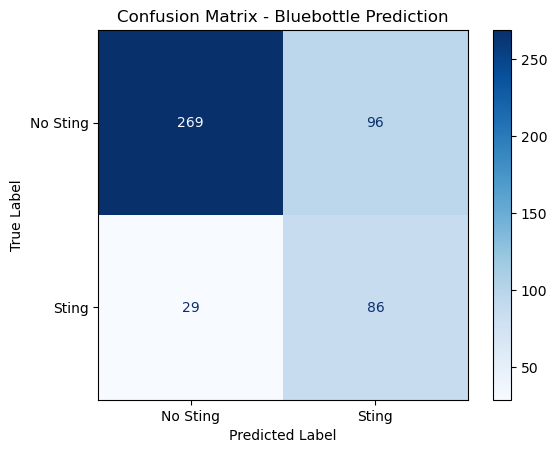


True Negatives: 269 | False Positives: 96
False Negatives: 29 | True Positives: 86

Precision = 0.473
Recall = 0.748
F1-score = 0.579


In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Sting", "Sting"])
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix - Bluebottle Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# percentages for clarity
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")

precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
print(f"\nPrecision = {precision:.3f}")
print(f"Recall = {recall:.3f}")
print(f"F1-score = {2 * (precision * recall) / (precision + recall + 1e-9):.3f}")
